In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, os

<i>To enable tensorboard, type:

'tensorboard --logdir . --host localhost --port 8888'

into a terminal and follow the http link.

For some reason i cannot launch properly it via VSCode extension nor via

%load_ext tensorboard

%tensorboard --logdir 'runs/ODE_brunton'</i>

# Train ODE time step transition
$$
\begin{cases}
\frac{\mathrm{d}x}{\mathrm{d}t} = \sigma(y-x)   \\
\frac{\mathrm{d}y}{\mathrm{d}t} = x(\rho-z) - y \\
\frac{\mathrm{d}z}{\mathrm{d}t} = x y  - \beta z
\end{cases}
$$

We have to teach Neural Network (NN) how to transition from state $\vec{r}_k = (x_k,y_k,z_k)$ to $\vec{r}_{k+1}$<br>
for times $t_k$ and $t_{k+1}$, from training data.

As far as i understand, NN will have to learn 
$$r_{k+1} = r_{k} + (\frac{\mathrm{d}x}{\mathrm{d}t},\frac{\mathrm{d}y}{\mathrm{d}t},\frac{\mathrm{d}z}{\mathrm{d}t} )\cdot\Delta t$$
$$\Delta t = t_{k+1} - t_k$$
***
We have data from ODE solution (file data_processing/differential_equation/ODE_01.ipynb),<br>
of:
* $T = 100$ trajectories 
* Each trajetory has $N = 800$ steps. 
* for 3 coordinates $x,y,z$. 

so data shape is $(T,N,3)$

In [2]:
dir = os.path.join('data_processing','media', 'Lorentz_system_sol')
with open(dir, 'rb') as f:
    descr,store_sol,store_init = pickle.load(f)

Ntraj, Nsteps, df = store_sol.shape
print(Ntraj, Nsteps, df)
descr

100 800 3


'contents: 1) describtion; 2) solution; 3) initial conditons. in 2) 100 trials of lorentz ODE systems. each trial has x,y,z coordinates for times 0:8:0.01'

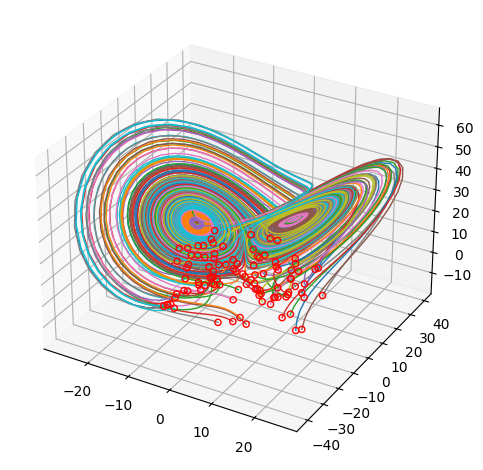

In [3]:
fig, ax = plt.subplots(1,subplot_kw=dict(projection='3d'),tight_layout=True)    
for init, traj in zip(store_init,store_sol):
    ax.plot(*traj.T, lw = 1)
    ax.scatter(*init, edgecolors='red', facecolor='none', zorder=2)

***
* There are $N-1$ transitions in each trajectory

Or $$T\times(N-1) = 79900$$ transitions in total

List of transitions can be split into two arrays- 'transition from' $\vec{f}$ and 'transition to' $\vec{t}$.

i.e for a single trajectory:
$$
\vec{f}_i \rightarrow \vec{t}_i:
\begin{bmatrix}
s_0 \\ s_1 \\ \vdots \\ s_{N-1}
\end{bmatrix}
\rightarrow
\begin{bmatrix}
s_1 \\ s_2 \\ \vdots \\ s_{N}
\end{bmatrix}
$$

and for M trajectories we combine:

$$
\begin{bmatrix}
\vec{f}_0  \\ \vec{f}_1  \\ \vdots \\ \vec{f}_M 
\end{bmatrix}
\rightarrow
\begin{bmatrix}
\vec{t}_0  \\ \vec{t}_1  \\ \vdots \\ \vec{t}_M 
\end{bmatrix}
$$

* First, get 'from' and 'to' data subsets by slicing

In [4]:
#points_start = np.zeros()
sol_start = store_sol[:,:-1]
sol_end= store_sol[:,1:]
print(sol_start.shape,sol_end.shape)

(100, 799, 3) (100, 799, 3)


* Join all starts and ends into one large list

In [5]:
nn_input_np = np.concatenate(sol_start , axis = 0)
nn_output_np = np.concatenate(sol_end  , axis = 0)
print(nn_input_np.shape,nn_output_np.shape)

(79900, 3) (79900, 3)


## Prepare a neural network

In [13]:
import torch
from torch.utils.data import DataLoader, random_split,TensorDataset, Dataset
from torch.optim import Adam
import torch.nn as nn
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
import datetime
#%load_ext tensorboard
#%tensorboard --logdir 'runs/ODE_brunton'
#tensorboard --logdir . --host localhost --port 8888
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

* define parameters

In [7]:
BATCH_SIZE = 200
INPUT_DIMS = 3
OUTPU_DIMS = 3
NODES = 20
P_TRAIN = 0.8 # this part of data for training

***
* Create a custom Dataset class
* Split data into training and validation subsets
* Create a Dataloader for both cases

In [8]:
class ODEDataset(Dataset):
    def __init__(self, data_in, data_out):
        self.x = data_in
        self.y = data_out

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

init_dataset = TensorDataset(
    torch.tensor(nn_input_np ).to(device, torch.float),
    torch.tensor(nn_output_np).to(device, torch.float)
    )

XY_train, XY_test = random_split(init_dataset, [P_TRAIN, 1-P_TRAIN])
data_loader_train   = DataLoader(XY_train, batch_size=BATCH_SIZE, shuffle=True)
data_loader_test    = DataLoader(XY_test, batch_size=BATCH_SIZE, shuffle=True)

### Custom activation functions

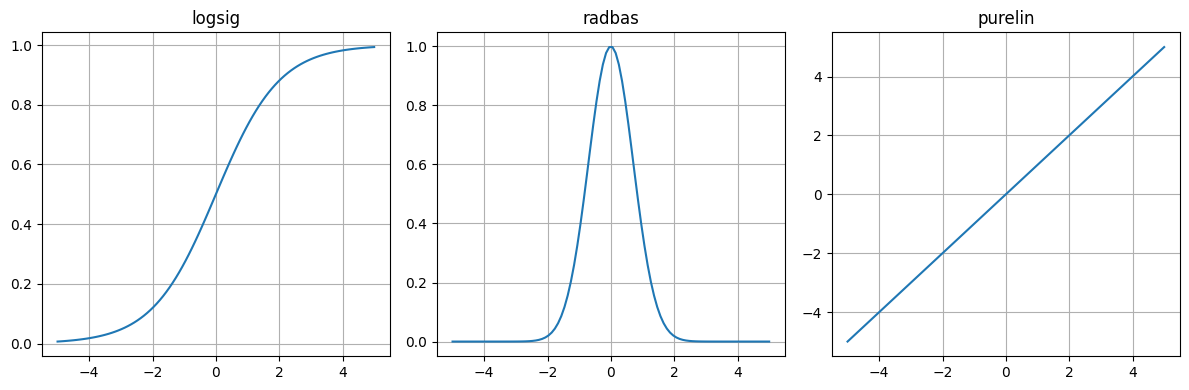

In [9]:
class logsig(nn.Module): 
    def __init__(self): 
        super(logsig, self).__init__() 
    
    def forward(self, x): 
        return torch.divide(1,(1 + torch.exp(-x)))

class radbas(nn.Module): 
    def __init__(self): 
        super(radbas, self).__init__() 
    
    def forward(self, x): 
        return torch.exp(-torch.pow(x,2))
    
class purelin(nn.Module): 
    def __init__(self): 
        super(purelin, self).__init__() 
    
    def forward(self, x): 
        return x

x           = torch.linspace(-5, 5, 100)    

fig, axs    = plt.subplots(1,3,tight_layout=True, figsize = (12,4)) 
classes     = [logsig,radbas,purelin]
names       = ['logsig','radbas','purelin']
for ax,cl,tit in zip(axs, classes, names):     
    ax.plot(x, cl()(x))
    ax.set_title(tit)
    ax.grid()


* Construct a NN architecture using dense layers and different activation functions

In [10]:
class net(nn.Module):
    def __init__(self):

        super(net, self).__init__()

        self.activation_1 = logsig()
        self.activation_2 = radbas()
        self.activation_3 = purelin()

        self.seq = nn.Sequential(
            nn.Linear(INPUT_DIMS, NODES),
            self.activation_1,
            nn.Linear(NODES, NODES),
            self.activation_2,
            nn.Linear(NODES, OUTPU_DIMS),
            self.activation_3
        )

    def forward(self,x):
        return self.seq(x)

model_lin = net()
summary(model_lin, input_size=(3,))

Layer (type:depth-idx)                   Output Shape              Param #
net                                      [3]                       --
├─Sequential: 1-1                        [3]                       --
│    └─Linear: 2-1                       [20]                      80
│    └─logsig: 2-2                       [20]                      --
│    └─Linear: 2-3                       [20]                      420
│    └─radbas: 2-4                       [20]                      --
│    └─Linear: 2-5                       [3]                       63
│    └─purelin: 2-6                      [3]                       --
Total params: 563
Trainable params: 563
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [17]:
num_epochs = 100
model_lin = model_lin.to(device)
criterion = nn.MSELoss()
optimizer = Adam(model_lin.parameters(), lr = 1e-3, weight_decay=1e-5)
now = datetime.datetime.now()
s2 = now.strftime("%H_%M_%S")
writer = SummaryWriter(fr'runs/ODE_brunton/{s2}')
step = 0
for i in range(num_epochs):
    for x,y in data_loader_train:
        optimizer.zero_grad()
        y_test = model_lin(x)
        loss   = criterion(y_test, y)
        loss.backward()
        optimizer.step()
        writer.add_scalar('Training Loss', loss, global_step=step)
        step += 1


### Test vs known trajectory


C:\Users\Hot Mexican\AppData\Local\Temp\ipykernel_21360\315637555.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(traj_known[0])


torch.Size([800, 3])


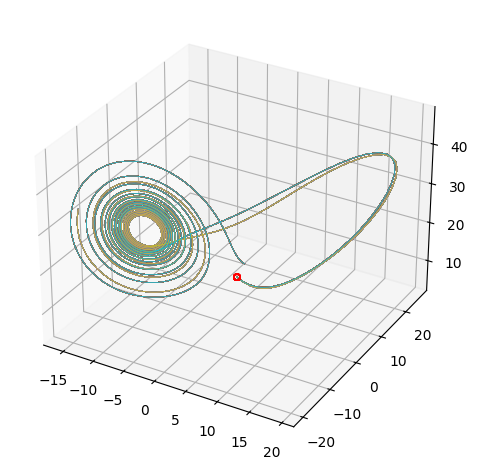

In [18]:
#%matplotlib inline
with torch.no_grad():
    model_lin2 = model_lin.cpu()
    traj_known = torch.tensor(store_sol[0]).to(torch.float)

    traj_sol = traj_known.clone()
    x1 = torch.tensor(traj_known[0])
    for i in range(len(traj_sol)-1):

        x2 = model_lin2(x1)
        traj_sol[i+1] = x2
        x1 = x2


    print(traj_sol.shape)

    fig, ax = plt.subplots(1,subplot_kw=dict(projection='3d'),tight_layout=True)    
    for init, traj in zip(store_init,store_sol):
        ax.plot(*traj_sol.T, lw = 0.5)
        ax.plot(*traj_known.T, lw = 0.5)
        ax.scatter(*traj_sol[0], edgecolors='red', facecolor='none', zorder=2)
    